# Welcome to SCARR!

This example notebook demonstrates how to use SCARR. It is not intended to explain the fundamentals of side-channel analysis.

Let us import the libraries needed to work with this Jupyter notebook:

In [1]:
import zarr
import matplotlib.pyplot as plt

## Getting Started with the Zarr File Format

Choose the data set to work with. Here, we use data set 'medium' with 100k traces, 70k samples per trace, and a data acquisition pattern of random plaintext with fixed key.

Please note: this data set is made available through Box.com (see link in SCARR's README.md). However, due to limitations of Box.com when downloading directories using the web interface, this data set can only be downloaded as a tar archive (.zarr.tar), i.e., this does not use any additional compression and simply offers the .zarr directory for download as a single file. After downloading this data set, you need to untar this archive. Download of the compressed data set is highly recommended.

In [2]:
#!tar -xvf benchmark_medium_sw_aes128_compressed.zarr.tar
# uncomment the above line, should you want to untar from within the Jupyter notebook

In [3]:
dataset_name = "benchmark_medium_sw_aes128_compressed.zarr"
#dataset_name = "benchmark_medium_sw_aes128.zarr"

Open the data set using Zarr:

In [4]:
dataset = zarr.open(dataset_name, "r")

Illustrate the structure of the data set:

In [5]:
dataset.tree()

Tree(nodes=(Node(disabled=True, name='/', nodes=(Node(disabled=True, name='0', nodes=(Node(disabled=True, name…

Accessing values in our data set works like so:

In [6]:
dataset["0/0/key"][0,:]

array([ 43, 126,  21,  22,  40, 174, 210, 166, 171, 247,  21, 136,   9,
       207,  79,  60], dtype=uint8)

The string "0/0" corresponds to X=0 and Y=0, and ["0/0/key"][0,:] will give you the first key used in the measurement campaign.

It is always helpful to confirm the compression setting.

In [7]:
dataset["0/0/traces"].compressor

Blosc(cname='lz4hc', clevel=9, shuffle=SHUFFLE, blocksize=0)

## Plotting a trace

In the same way we accessed a key, we can also access trace data. Dataset medium will clearly show 10 rounds of the software AES. Let us plot the first trace in our data set.

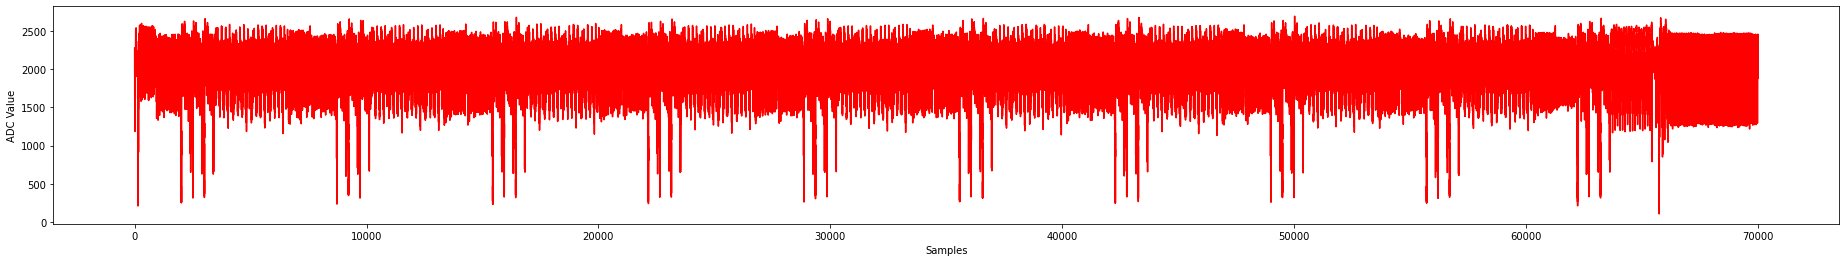

In [8]:
fig, ax = plt.subplots(figsize=(32, 4))
ax.plot(dataset["0/0/traces"][0,:], color='red')

ax.set_xlabel('Samples')
ax.set_ylabel('ADC Value')
plt.show()

## SNR with SCARR

Computing the Signal-to-Noise Ratio (SNR) is a good start to explore this data set from a side-channel perspective. First, we need to configure everything.

In [9]:
from scarr.engines.snr import SNR as snr
from scarr.file_handling.trace_handler import TraceHandler as th
from scarr.container.container import Container, ContainerOptions

handler = th(fileName=dataset_name)
engine = snr()

container = Container(options=ContainerOptions(engine=engine, handler=handler))

opened zarr file  benchmark_medium_sw_aes128_compressed.zarr


Executing the following cell will run the computation for the first byte position (word) of AES.

In [10]:
# this should be quite fast on most modern computers (<1 min)
engine.run(container)

Fetching the results ...

In [11]:
results = engine.get_result()

Looking at the results.shape is helpful to understand. Here: (tile, byte position, sample) = (1,1,70000)

In [12]:
results.shape

(1, 1, 70000)

Let us plot the result. This will show distinctive peaks in the range of [0:5000] as can be cross-checked with other side-channel analysis frameworks.

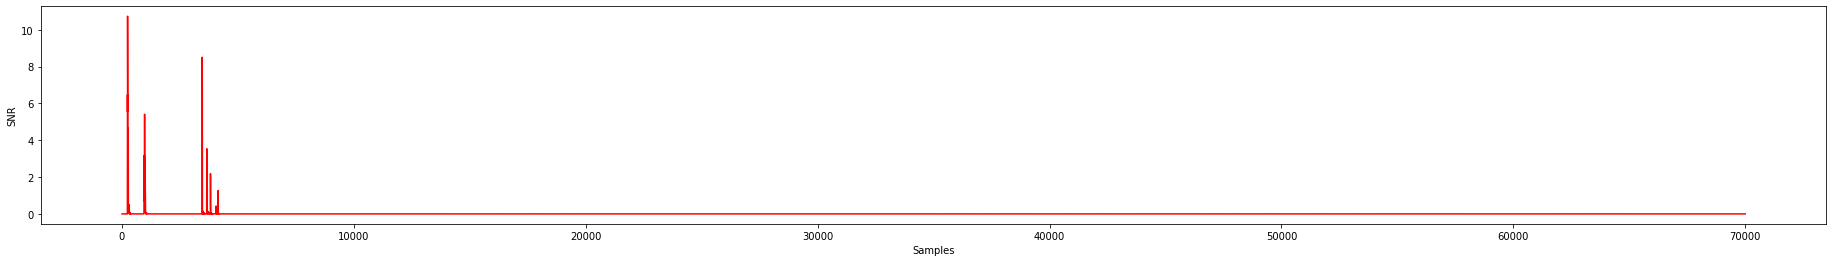

In [13]:
fig, ax = plt.subplots(figsize=(32, 4))
ax.plot(results[0,0,:], color='red')

ax.set_xlabel('Samples')
ax.set_ylabel('SNR')
plt.show()

## CPA with SCARR

With the following code, we perform a Correlation Power Analysis with the HammingWeight (HW) power model.

In [14]:
from scarr.engines.cpa import CPA as cpa
from scarr.file_handling.trace_handler import TraceHandler as th
from scarr.models.subBytes_weight import SubBytes_weight
from scarr.container.container import Container, ContainerOptions

In [15]:
handler2 = th(fileName=dataset_name)
model = SubBytes_weight()
engine2 = cpa(model)
container2 = Container(options=ContainerOptions(engine=engine2, handler=handler2))

opened zarr file  benchmark_medium_sw_aes128_compressed.zarr


Executing the following cell will run the computation for the first byte position (word) of the AES.

In [16]:
# this should be quite fast on most modern computers (<2 min)
container2.run()

Fetching the results ...

In [17]:
results2 = container2.engine.get_result()

Looking at the results.shape is helpful to understand. Here: (tile, byte position, convergence_step, key candidate, sample) = (1,1,1,256,70000)

In [18]:
results2.shape

(1, 1, 1, 256, 70000)

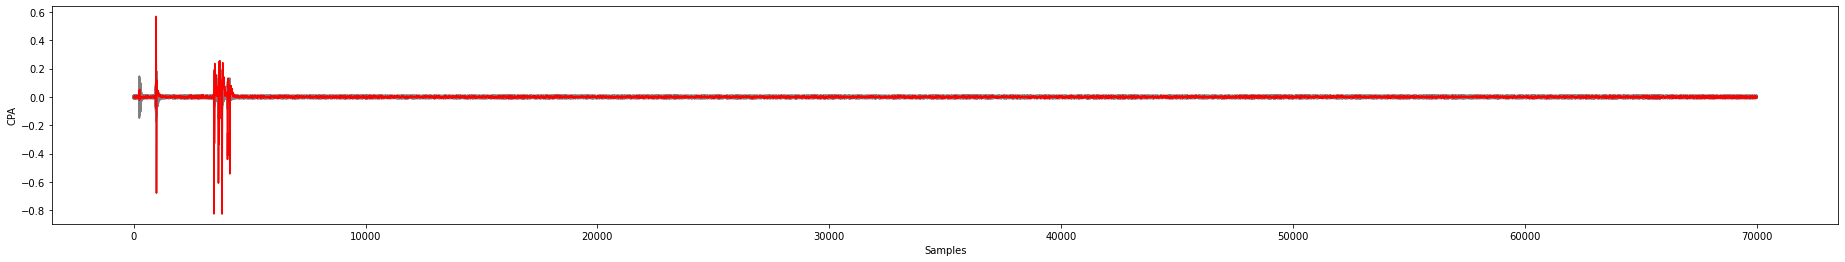

In [19]:
fig, ax = plt.subplots(figsize=(32, 4))
ax.plot(results2[0,0,0,:,:].T, color='gray')
ax.plot(results2[0,0,0,dataset["0/0/key"][0,0],:].T, color='red')

ax.set_xlabel('Samples')
ax.set_ylabel('CPA')
plt.show()

## MIA with SCARR

With the following code, we perform a Mutual Information Analysis with the HammingWeight (HW) power model and chosen number of bins.

In [20]:
from scarr.engines.mia import MIA as mia
from scarr.file_handling.trace_handler import TraceHandler as th
from scarr.models.subBytes_weight import SubBytes_weight
from scarr.container.container import Container, ContainerOptions

In [21]:
handler3 = th(fileName=dataset_name)
model = SubBytes_weight()
bin_num = 9
engine3 = mia(model, bin_num)
container3 = Container(options=ContainerOptions(engine=engine3, handler=handler3), slice=[0,5000])

opened zarr file  benchmark_medium_sw_aes128_compressed.zarr


Executing the following cell will run the computation.

In [22]:
# this should be quite fast on most modern computers (<2 min)
container3.run()


Let us check the returned key candidate (43=0x2b)

In [23]:
results3 = container3.engine.get_result()
candidates = engine3.get_candidate()
print(candidates)

[[[43]]]


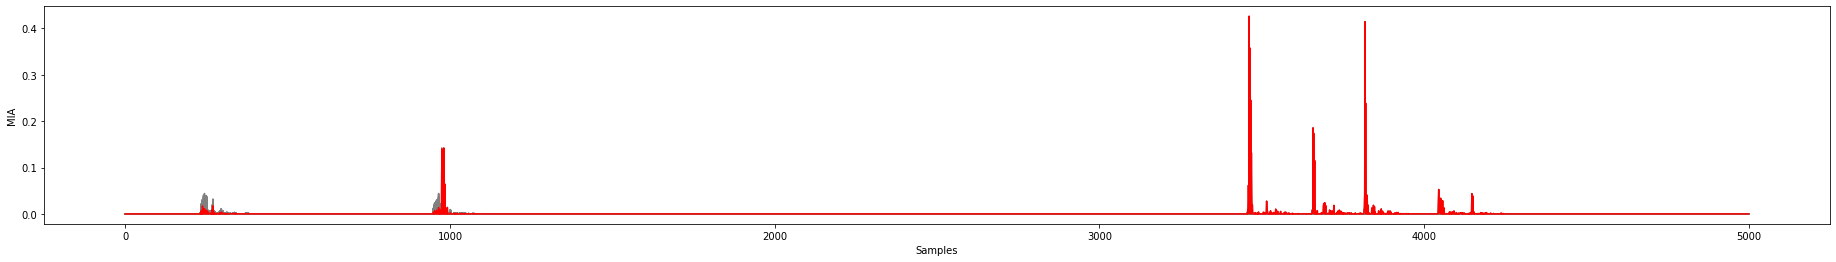

In [24]:
fig, ax = plt.subplots(figsize=(32, 4))
ax.plot(results3[0,0,0,:,:].T, color='gray')
ax.plot(results3[0,0,0,dataset["0/0/key"][0,0],:], color='red')

ax.set_xlabel('Samples')
ax.set_ylabel('MIA')
plt.show()

# Congratulations!

You successfully started using SCARR and are now off to great adventures in the domain of side-channel analysis!